# DSCI 571 - Supervised Learning I

# Lab 1: Decision trees and machine learning fundamentals

## Table of Contents

- [Submission instructions](#si) (5%)
- [Exercise 1: Decision trees with a toy dataset](#1) (20%)
- [Exercise 2: Decision trees with Spotify Song Attributes dataset](#2) (25%)
- [Exercise 3: Data splitting and model building](#3) (25%)
- [Exercise 4: Hyperparameters](#4) (25%)
- (Optional) [Exercise 5](#5) 

<br><br>

## Imports

In [1]:
import re
import sys
from hashlib import sha1

import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tests_lab1
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import altair as alt

from IPython.display import Image

<br><br>

## Submission instructions <a name="si"></a>
<hr>
rubric={mechanics:5}

You will receive marks for correctly submitting this assignment. To submit this assignment, follow the instructions below:

- **Please add a link to your GitHub repository here: https://github.ubc.ca/mds-2021-22/DSCI_571_lab1_macychan*
- Be sure to follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- Make at least three commits in your lab's GitHub repository.
- Push the final .ipynb file with your solutions to your GitHub repository for this lab.
- Upload the .ipynb file to Gradescope.
- Make sure that your plots/output are rendered properly in Gradescope.

> [Here](https://github.com/UBC-MDS/public/tree/master/rubric) you will find the description of each rubric used in MDS.


> Note: The data you download for use in this lab **SHOULD NOT BE PUSHED TO YOUR REPOSITORY**. You might be penalised for pushing datasets to your repository. I have seeded the repository with `.gitignore` and hoping that it won't let you push CSVs.

<br><br>

## Exercise 1: Decision trees with a toy dataset <a name="1"></a>
<hr>

Suppose you have three different job offers with comparable salaries and job descriptions. You want to decide which one to accept, and you want to make this decision based on which job is likely to make you happy. Being a very systematic person, you come up with three features associated with the offers, which are important for your happiness: whether the colleagues are supportive, work-hour flexibility, and whether the company is a start-up or not. So the `X` of your offer data looks as follows: 

In [2]:
offer_data = {
    # Features
    "supportive_colleagues": [1, 0, 0],
    "work_hour_flexibility": [0, 0, 1],
    "start_up": [0, 1, 1],
}

offer_df = pd.DataFrame(offer_data)
offer_df

,supportive_colleagues,work_hour_flexibility,start_up
0,1,0,0
1,0,0,1
2,0,1,1


Your goal is to get predictions for these rows. In other words, for each row, you want to predict whether that job would make you happy or unhappy.   

So you ask the following questions to some of your friends (who you think have similar notions of happiness) regarding their jobs:

1. Do you have supportive colleagues? (1 for 'yes' and 0 for 'no')
2. Do you have flexible work hours? (1 for 'yes' and 0 for 'no')
3. Do you work for a start-up? (1 for 'start up' and 0 for 'non start up')
4. Are you happy in your job? (happy or unhappy)

You get the following data from this toy survey. You decide to train a machine learning model using this toy survey data and then use this model to predict which job is likely to make you happy. 

In [3]:
import pandas as pd

happiness_data = {
    # Features
    "supportive_colleagues": [1, 1, 1, 0, 0, 1, 1, 0, 1, 0],
    "work_hour_flexibility": [1, 1, 0, 1, 1, 0, 1, 0, 0, 0],
    "start_up": [1, 0, 1, 0, 1, 0, 0, 1, 1, 0],
    # Target
    "target": [
        "happy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "happy",
        "happy",
        "unhappy",
        "unhappy",
        "unhappy",
    ],
}

train_df = pd.DataFrame(happiness_data)
train_df

,supportive_colleagues,work_hour_flexibility,start_up,target
0,1,1,1,happy
1,1,1,0,happy
2,1,0,1,happy
3,0,1,0,unhappy
4,0,1,1,unhappy
5,1,0,0,happy
6,1,1,0,happy
7,0,0,1,unhappy
8,1,0,1,unhappy
9,0,0,0,unhappy


### 1.1 Decision stump by hand 
rubric={accuracy:3}

**Your tasks:**

With this toy dataset, build a decision stump (decision tree with only 1 split) by splitting on the condition `supportive_colleagues <= 0.5`. What training accuracy would you get with this decision stump? 

Save the accuracy as a decimal in an object named `supportive_colleagues_acc`. 

In [4]:
train_df[["supportive_colleagues", "target"]]
predict_hand = pd.DataFrame(
    {
        "target": train_df["target"],
        "predict": train_df["supportive_colleagues"].map(
            lambda x: "unhappy" if x <= 0.5 else "happy"
        ),
    }
)

predict_hand["score"] = predict_hand["target"] ==  predict_hand["predict"]
predict_hand

,target,predict,score
0,happy,happy,True
1,happy,happy,True
2,happy,happy,True
3,unhappy,unhappy,True
4,unhappy,unhappy,True
5,happy,happy,True
6,happy,happy,True
7,unhappy,unhappy,True
8,unhappy,happy,False
9,unhappy,unhappy,True


In [5]:
supportive_colleagues_acc = sum(predict_hand['score'])/len(predict_hand)
supportive_colleagues_acc

0.9

In [6]:
assert tests_lab1.ex1_1(
    supportive_colleagues_acc
), "Your answer is incorrect, see traceback above."
print("Success")

Success


<br><br>

### 1.2 Create `X`, `y`
rubric={accuracy:3}

Recall that in `scikit-learn`, before building a classifier we need to create `X` (features) and `y` (target). 

**Your tasks:**

From `train_df`, create `X` and `y`, and save them in objects named `X` and `y`, respectively. 

In [7]:
X = train_df.drop(columns="target")
y = train_df.iloc[:, 3]

print(X)
print(y)

   supportive_colleagues  work_hour_flexibility  start_up
0                      1                      1         1
1                      1                      1         0
2                      1                      0         1
3                      0                      1         0
4                      0                      1         1
5                      1                      0         0
6                      1                      1         0
7                      0                      0         1
8                      1                      0         1
9                      0                      0         0
0      happy
1      happy
2      happy
3    unhappy
4    unhappy
5      happy
6      happy
7    unhappy
8    unhappy
9    unhappy
Name: target, dtype: object


In [8]:
assert tests_lab1.ex1_2(X, y), "Your answer is incorrect, see traceback above."
print("Success")

Success


<br><br>

### 1.3 `fit` a decision tree classifier 
rubric={accuracy:3}

**Your tasks:**

Create a `DecisionTreeClassifier` with `random_state=16` and store it in a variable called `toy_tree`. Now `fit` the classifier on the `X` and `y` created above. 

In [9]:
toy_tree = DecisionTreeClassifier(random_state=16)
toy_tree.fit(X, y)

DecisionTreeClassifier(random_state=16)

<br><br>

### 1.4 Visualize the trained decision tree
rubric={viz:4}

**Your tasks:**

1. Visualize the decision tree model build for the toy data using the `graphviz` package. 
2. What's the depth of the learned decision tree model? 

> You may adapt the following helper code from the lecture notes to visualize the tree.   

In [10]:
def display_tree(feature_names, tree, counts=False):
    """For binary classification only"""
    dot = export_graphviz(
        tree,
        out_file=None,
        feature_names=feature_names,
        class_names=tree.classes_.astype(str),
        impurity=False,
    )
    # adapted from https://stackoverflow.com/questions/44821349/python-graphviz-remove-legend-on-nodes-of-decisiontreeclassifier
    # dot = re.sub('(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])(\\\\nclass = [A-Za-z0-9]+)', '', dot)
    if counts:
        dot = re.sub("(samples = [0-9]+)\\\\n", "", dot)
        dot = re.sub("value", "counts", dot)
    else:
        dot = re.sub(
            "(\\\\nsamples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])", "", dot
        )
        dot = re.sub(
            "(samples = [0-9]+)(\\\\nvalue = \[[0-9]+, [0-9]+\])\\\\n", "", dot
        )

    return graphviz.Source(dot)

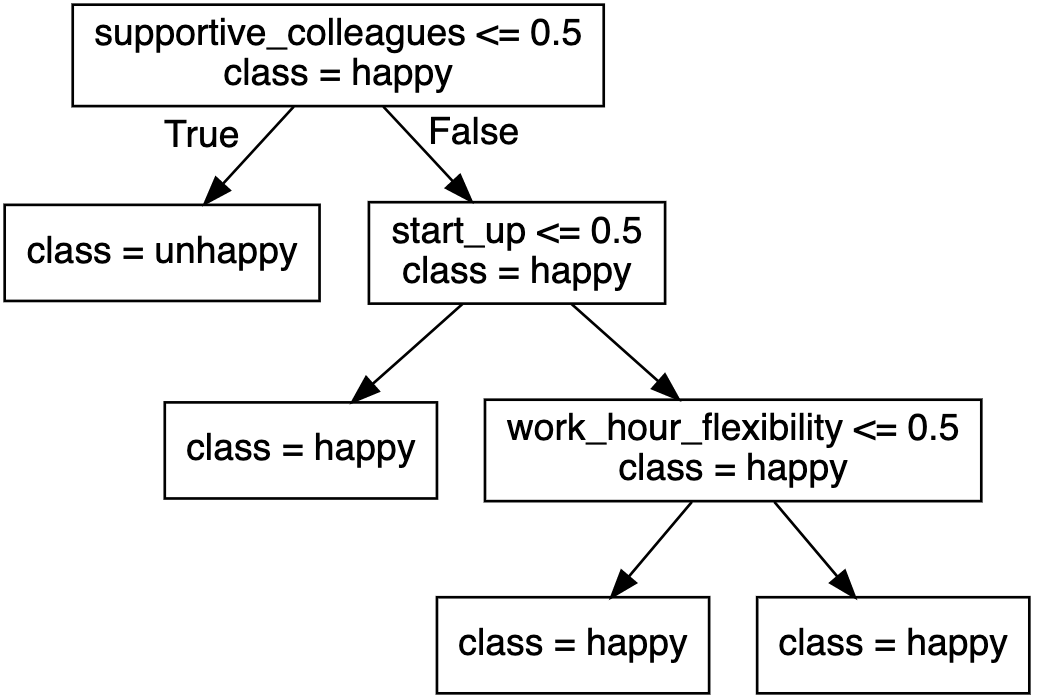

In [11]:
# display_tree(X.columns, toy_tree)
Image("q1_4.png", width=500)

The depth of the tree is 3.

### 1.5 Accuracy on the training data
rubric={reasoning:4}

**Your tasks:**

Evaluate the `toy_tree` (call `score()`) on the training data (i.e., `X` and `y`). Do you get perfect training accuracy? Why or why not? 

In [12]:
toy_tree.score(X, y)

0.9

No, the score is 0.9 but 1. By looking at the tree visually, "unhappy" only appears when "supportive_colleagues" is less than 0.5, otherwise, it is "happy". This trained model does not consider the rest of the two elements "start_up" and "work_hour_flexibility", which may lead to imperfect accuracy. However, an overfitted model does not imply perfect prediction for new data.

<br><br>

### 1.6 Predicting on the offer data 
rubric={reasoning:3}

**Your tasks:**

Now `predict` on `offer_df`. In which job you are likely to be happy? 

In [13]:
toy_tree.predict(offer_df)

array(['happy', 'unhappy', 'unhappy'], dtype=object)

I might prefer the first job by the result, which is the only job with outcome 'happy'.

<br><br><br><br>

## Exercise 2: Decision trees on Spotify Song Attributes dataset <a name="2"></a>
<hr>

### Introducing the dataset
  
For the rest of the lab you'll be using Kaggle's [Spotify Song Attributes](https://www.kaggle.com/geomack/spotifyclassification/home) dataset. The dataset contains a number of features of songs from 2017 and a binary variable `target` that represents whether the user liked the song (encoded as 1) or not (encoded as 0). See the documentation of all the features [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). 

This dataset is publicly available on Kaggle, and you will have to download it yourself. Follow the steps below to get the data CSV. 

1. If you do not have an account with [Kaggle](https://www.kaggle.com/), you will first need to create one (it's free).
2. Login to your account and [download](https://www.kaggle.com/geomack/spotifyclassification/download) the dataset.
3. Unzip the data file if needed, then rename it to `spotify.csv`, and move it to the same directory as this notebook.

> You will not be able to push it to your repository (hopefully) because I have seeded the repository wich `.gitignore`.

### 2.1 Reading the data CSV
rubric={accuracy:3}

Read in the data CSV and store it as a pandas dataframe named `spotify_df`. The first column of the .csv file should be set as the index.

In [14]:
spotify_df = pd.read_csv('data.csv', index_col = 0 )
spotify_df

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,target,song_title,artist
0,0.01020,0.833,204600,0.434,0.021900,2,0.1650,-8.795,1,0.4310,150.062,4.0,0.286,1,Mask Off,Future
1,0.19900,0.743,326933,0.359,0.006110,1,0.1370,-10.401,1,0.0794,160.083,4.0,0.588,1,Redbone,Childish Gambino
2,0.03440,0.838,185707,0.412,0.000234,2,0.1590,-7.148,1,0.2890,75.044,4.0,0.173,1,Xanny Family,Future
3,0.60400,0.494,199413,0.338,0.510000,5,0.0922,-15.236,1,0.0261,86.468,4.0,0.230,1,Master Of None,Beach House
4,0.18000,0.678,392893,0.561,0.512000,5,0.4390,-11.648,0,0.0694,174.004,4.0,0.904,1,Parallel Lines,Junior Boys
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,0.00106,0.584,274404,0.932,0.002690,1,0.1290,-3.501,1,0.3330,74.976,4.0,0.211,0,Like A Bitch - Kill The Noise Remix,Kill The Noise
2013,0.08770,0.894,182182,0.892,0.001670,1,0.0528,-2.663,1,0.1310,110.041,4.0,0.867,0,Candy,Dillon Francis
2014,0.00857,0.637,207200,0.935,0.003990,0,0.2140,-2.467,1,0.1070,150.082,4.0,0.470,0,Habit - Dack Janiels & Wenzday Remix,Rain Man
2015,0.00164,0.557,185600,0.992,0.677000,1,0.0913,-2.735,1,0.1330,150.011,4.0,0.623,0,First Contact,Twin Moons


<br><br>

### 2.2 Data splitting 
rubric={accuracy:2}

Run the following line of code to split the data. How many training and test examples do we have?

> Note: we are setting the `random_state` so that everyone has the same split on their assignments. This will make it easier for the TAs to grade.

In [15]:
train_df, test_df = train_test_split(spotify_df, test_size=0.2, random_state=123)
print(train_df.shape)
print(test_df.shape)

(1613, 16)
(404, 16)


We have 1613 examples in training data, 404 examples in test data.

<br><br>

### 2.3 `describe` and `info`
rubric={accuracy:5}

**Your tasks:**

1. Show output of `info()` on the **training split**. 
2. Print out the output of `describe()` **on the training split**. This will compute some summary statistics of the numeric columns.
3. Which feature has the smallest range? 

> Hint: You can subtract the min value from the max value of the column to get the range.


> Note that `describe` returns another DataFrame.

In [16]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1613 entries, 1505 to 1534
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      1613 non-null   float64
 1   danceability      1613 non-null   float64
 2   duration_ms       1613 non-null   int64  
 3   energy            1613 non-null   float64
 4   instrumentalness  1613 non-null   float64
 5   key               1613 non-null   int64  
 6   liveness          1613 non-null   float64
 7   loudness          1613 non-null   float64
 8   mode              1613 non-null   int64  
 9   speechiness       1613 non-null   float64
 10  tempo             1613 non-null   float64
 11  time_signature    1613 non-null   float64
 12  valence           1613 non-null   float64
 13  target            1613 non-null   int64  
 14  song_title        1613 non-null   object 
 15  artist            1613 non-null   object 
dtypes: float64(10), int64(4), object(2)
mem

In [17]:
train_df_diff = train_df.describe()
(train_df_diff.loc['max'] - train_df_diff.loc['min']).sort_values()

speechiness              0.792900
danceability             0.862000
liveness                 0.950200
valence                  0.956100
instrumentalness         0.976000
energy                   0.982200
acousticness             0.994995
mode                     1.000000
target                   1.000000
time_signature           4.000000
key                     11.000000
loudness                32.790000
tempo                  171.472000
duration_ms         833918.000000
dtype: float64

speechiness returns the smallest value.

<br><br>

### 2.4 Plotting histograms 
rubric={viz:5}

The starter code below produces histograms for the `loudness` feature which shows the distribution of the feature values in the training set, separated for positive (target=1, i.e., user liked the song) and negative (target=0, i.e., user disliked the song) examples. There are two different histograms, one for target = 0 and one for target = 1, and they are overlaid on top of each other. The histogram shows that extremely quiet songs tend to be disliked (more blue bars than orange on the left) and very loud songs also tend to be disliked (more blue than orange on the far right).

> Note: I am using pandas plotting here, which I believe you have learned in 511. You'll be learning `altair` for producing prettier plots in the program and you are welcome to use it or any other tool of your choice for plotting here. 

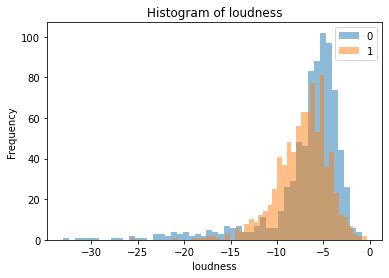

In [18]:
feat = "loudness"
ax = train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
plt.xlabel(feat)
plt.title("Histogram of " + feat)
plt.show()

**Your tasks:**

Create histograms for the following features in the order below.
- acousticness
- danceability
- tempo
- energy
- valence

> To adhere to the [DRY (Don't Repeat Yourself)](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself) principle, make sure you use a `for` loop for your plotting, rather than repeating the plotting code 4 times. For this to work, I used `plt.show()` at the end of your loop, which draws the figure and resets the canvas for your next plot.

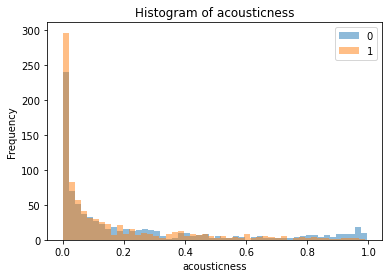

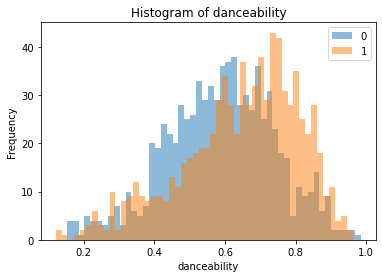

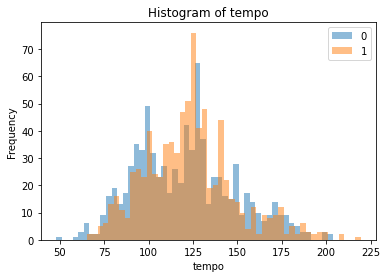

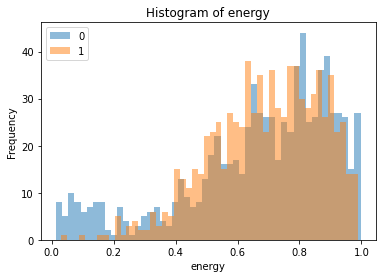

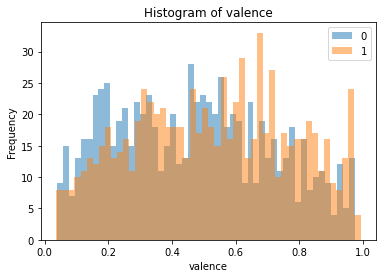

In [19]:
features = ['acousticness', 'danceability', 'tempo', 'energy', 'valence']
features
def ax(feat):
    train_df.groupby("target")[feat].plot.hist(bins=50, alpha=0.5, legend=True)
    plt.xlabel(feat)
    plt.title("Histogram of " + feat)
    plt.show()

for feat in features:
    ax(feat)

<br><br>

### 2.5 Decision stump by hand 
rubric={reasoning:3}

**Your tasks:**

Let's say you had to make a decision stump (decision tree with depth 1), _by hand_, to predict the target class. Just from looking at the plots above, describe a reasonable split (feature name and threshold) and what class you would predict in the two cases. For example, in the loudness histogram provided earlier on, it seems that very large values of loudness are generally disliked (more blue on the right side of the histogram), so you might answer something like this: "A reasonable split would be to predict 0 if loudness > -5 (and predict 1 otherwise)."

A reasonable split would be to predict 0 if energy < 0.2, otherwise, predict 1.

<br><br>

### 2.6 Identical histograms
rubric={reasoning:3}

**Your tasks:**

Let's say that, for a particular feature, the histograms of that feature are identical for the two target classes. Does that mean the feature is not useful for predicting the target class?



Yes, the difference between the features correlate to two target classes are used to distinguish whether the example should go to either one of the target classes. If two histograms are identical, no difference can be found, hence no useful information to distinguish between to target classes.

### 2.7 Which columns to include? 
rubric={reasoning:4}

**Your tasks:**

Note that the dataset includes two free text features labeled `song_title` and `artist`. Do you think these features could be useful in predicting whether the user liked the song or not? Would there be any difficulty in using them in your model?   

`artist` can be useful in the prediction while `song_title` may be less useful. As many listeners may like the songs because of the artist, some popular singer like Taylor Swift, could be more favorable these days comparing to some older generation artists. However, song title may not be critical for user to like or dislike a song.  
Technically, DecisionTreeClassifier can handle text like categorical labels by treating them as `numeric`. But it will be difficulty to use since both `song_title` and `artist` are free text, which is not categorical labels with limited categories. The possible combinations are huge, hence hard to use them in the tree model.

<br><br><br><br>

## Exercise 3: Data splitting and model building <a name="3"></a>
<hr>
Recall that in machine learning what we care about is generalization; we want to build models that generalize well on unseen examples. One way to approximate generalization error is by splitting the data into train and test splits, building and tuning the model only using the train split, and carrying out the final assessment on the test split. 

In Exercise 2.2, we used `scikit-learn`'s [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to split the data, which shuffles the data before splitting. In this exercise, we will try to convince ourselves the importance of shuffling before splitting. 

The starter code below creates `X` and `y` for you to use in the following questions. In the exercises below, you'll have to calculate `train` and `test` scores several times. To make it a bit easy for you, I am providing you a function `fit_and_report` below, which fits a model and prints train and test scores. Feel free to use this function in the following exercises. 

In [20]:
X = spotify_df.drop(columns=["song_title", "artist", "target"])
y = spotify_df["target"]

In [21]:
def fit_and_report(model, X_train, y_train, X_test, y_test):
    """
    Fits a given model on the training data and prints train and
    test scores.

    Parameters
    ----------
    model: sklearn classifier model
        The sklearn model
    X_train: numpy.ndarray
        The X_train part of the data
    y_train: numpy.ndarray
        The y_train part of the data
    X_test: numpy.ndarray
        The X_train part of the data
    y_test: numpy.ndarray
        The y_test part of the data

    Returns
    -------
        None
    """
    model.fit(X_train, y_train)
    print("Training score: %0.3f" % (model.score(X_train, y_train)))
    print("Test score: %0.3f" % (model.score(X_test, y_test)))

<br><br>

### 3.1 Splitting without shuffling 
rubric={accuracy:4}

The dataset has total 2,017 examples. 

**Your tasks:**  

1. Split `X` and `y` as follows: 
    - Use the first 1500 rows as the train set (`X_train` and `y_train`)
    - Use the remaining rows as the test set (`X_test` and `y_test`)
2. Train `DummyClassifier` on the train set and score it on the train and test sets.
3. Now train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

> You may use the `fit_and_report` function above to `fit` and `score` models.  

> If parameter values are not specified explicitly, you may use the default values. 

In [22]:
X_train, X_test = X.iloc[:1500,:], X.iloc[1500:,:]
y_train, y_test = y.iloc[:1500,], y.iloc[1500:,]

print('DummyClassifier:')
model_dummy = DummyClassifier()
fit_and_report(model_dummy, X_train, y_train, X_test, y_test)

print('DecisionTreeClassifier:')
model_tree = DecisionTreeClassifier(random_state=123)
fit_and_report(model_tree, X_train, y_train, X_test, y_test)


DummyClassifier:
Training score: 0.680
Test score: 0.000
DecisionTreeClassifier:
Training score: 0.998
Test score: 0.491


<br><br>

### 3.2 Splitting with shuffling 
rubric={accuracy:4}

The problem in the previous exercise was that we did not shuffle the training examples before splitting. Let's see if shuffling the data improves the test score.

**Your tasks:** 

1. Run the starter code below to shuffle `X` and `y`. 
2. Split the **shuffled data** as follows: 
    - Use the first 1500 rows as the train set 
    - Use the remaining rows as the test set
3. Train `DummyClassifier` on the train set and score it on the train and test sets.    
4. Now train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

In [23]:
X_shuffled = X.reindex(np.random.permutation(X.index))
y_shuffled = y.reindex(X_shuffled.index)

In [24]:
X_train, X_test = X_shuffled.iloc[:1500,:], X_shuffled.iloc[1500:,:]
y_train, y_test = y_shuffled.iloc[:1500,], y_shuffled.iloc[1500:,]

print('DummyClassifier:')
model_dummy = DummyClassifier()
fit_and_report(model_dummy, X_train, y_train, X_test, y_test)

print('DecisionTreeClassifier:')
model_tree = DecisionTreeClassifier(random_state=123)
fit_and_report(model_tree, X_train, y_train, X_test, y_test)


DummyClassifier:
Training score: 0.510
Test score: 0.493
DecisionTreeClassifier:
Training score: 0.999
Test score: 0.662


<br><br>

### 3.3 Splitting with `train_test_split` 
rubric={accuracy:4}

**Your tasks:** 

1. Now split the Spotify dataset into a 80% train and 20% test using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) with `random_state=123`.
2. Train `DummyClassifier` on the train set and score it on the train and test sets.    
3. Train the `DecisionTreeClassifier` with `random_state=123` on the train set and score it on the train and test sets. 

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

print('DummyClassifier:')
model_dummy = DummyClassifier()
fit_and_report(model_dummy, X_train, y_train, X_test, y_test)

print('DecisionTreeClassifier:')
model_tree = DecisionTreeClassifier(random_state=123)
fit_and_report(model_tree, X_train, y_train, X_test, y_test)

DummyClassifier:
Training score: 0.508
Test score: 0.498
DecisionTreeClassifier:
Training score: 0.999
Test score: 0.688


<br><br>

### 3.4 Discussion
rubric={reasoning:4}

**Your tasks:** 
1. Why do you think we got a lower test accuracy on the Spotify Song Attributes datasets when we did not shuffle the data before splitting compared to when we shuffled the data before splitting?  
2. Do you expect `DummyClassifier` to be sensitive to data shuffling and splitting? Why or why not?     

1. When a dataset is provided, it might be sorted, which makes the data has bias if we do not pick our data randomly. We want a set of training data that can represent the whole data set, therefore, shuffling is necessary.
2. Yes, it is very sensitive to shuffling and splitting. Since DummyClassifier only look at the frequency of y, if y is sorted, or not randomly distributed, the model will have bias. In our example, most of the ones are at the top of the data set while zeros at the bottom, when we count the training data without shuffle, naturally the model will predict 1 for all cases, and fail when we apply it to test data.

In [26]:
y.head(5)

0    1
1    1
2    1
3    1
4    1
Name: target, dtype: int64

In [27]:
y.tail(5)

2012    0
2013    0
2014    0
2015    0
2016    0
Name: target, dtype: int64

<br><br>

### 3.5 Cross-validation
rubric={accuracy:4}

**Your tasks:** 

Carry out 10-fold cross validation using `cross_validate` on `X_train` and `y_train` from Exercise 3.3 by passing `return_train_score=True`. Display the results as a pandas dataframe. 

In [28]:
scores = pd.DataFrame(cross_validate(model_tree, X_train, y_train, cv=10, return_train_score=True))
scores

,fit_time,score_time,test_score,train_score
0,0.018726,0.002628,0.722222,0.999311
1,0.019385,0.003403,0.660494,1.000000
2,0.016185,0.001994,0.660494,0.999311
3,0.017209,0.001832,0.677019,1.000000
4,0.015630,0.001782,0.695652,0.999311
5,0.016298,0.001808,0.652174,0.999311
6,0.014877,0.001813,0.658385,0.999311
7,0.014943,0.001601,0.608696,0.999311
8,0.014754,0.002051,0.683230,0.999311
9,0.015762,0.001740,0.695652,0.999311


<br><br>

### 3.6 Examining cross-validation scores
rubric={reasoning:5}

**Your tasks:** 
1. Inspect the 10 sub-scores from the 10 folds of cross-validation. How does this inform the trustworthiness of your mean cross-validation score?
2. Do you see a significant difference between the training scores and the cross-validation scores? Briefly discuss in 1 to 2 sentences. 

1. Not trustworthy. The range of validation score is large, from 0.62 to 0.75 (different > 0.12), which indicates that by changing the combination of validation and training data, it can vary. It is not trustworthy because of the steadiness.

In [29]:
scores['test_score'].max()-scores['test_score'].min()

0.11352657004830913

In [30]:
scores_melt = scores.melt(
    id_vars=["fit_time", "score_time"], var_name="score_type", value_name="score"
).query('score_type == "test_score"')
test_score_boxplot = (
    alt.Chart(scores_melt)
    .mark_boxplot()
    .encode(
        y="score_type",
        x=alt.X("score", scale=alt.Scale(domain=[0.6, 0.8])),
        color="score_type",
    )
)
test_score_boxplot

alt.Chart(...)

2. Yes, the difference between training mean and cross-validation mean is large, while training mean is close to 1, the cross-validation mean is only 0.66. It indicates that the model is overfitting.

In [31]:
scores['test_score'].mean()

0.6714017329959358

In [32]:
scores['train_score'].mean()

0.9994489408843148

<br><br><br><br>

## Exercise 4: Hyperparameters <a name="4"></a>
<hr>

### 4.1 Train and cross-validation plots
rubric={accuracy:12}

In this exercise, you'll experiment with the `max_depth` hyperparameter of the decision tree classifier. See the [`DecisionTreeClassifier` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for more details.

**Your tasks:**

1. Just to start fresh, split the Spotify dataset into a 80% train and 20% test subset using [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and `random_state=123`.
2. Explore the `max_depth` hyperparameter. Run 10-fold cross-validation for trees with different values of `max_depth` (at least 10 different values in the range 1 to 25). 
3. For each `max_depth`, get both the train accuracy and the cross-validation accuracy.
4. Make a plot with `max_depth` on the *x*-axis and the train and cross-validation scores on the *y*-axis. That is, your plot should have two curves, one for train and one for cross-validation. Include a legend to specify which is which.

> You may use whatever tool you like for plotting. We also have done something similar in lecture 2, and you may adapt that code to answer this question. 

> Note: generally speaking (for all assignments) you are welcome to copy/paste code directly from the lecture notes, though I ask that you add a small citation (e.g. "Adapted from lecture 2") if you do so.

<AxesSubplot:xlabel='depth'>

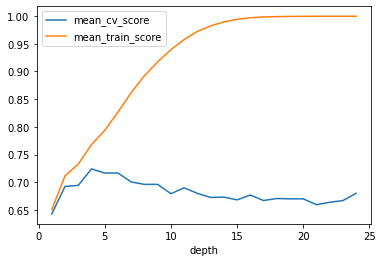

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=123
)

result_dict = pd.DataFrame(columns=["depth", "mean_cv_score", "mean_train_score"])
for depth in np.arange(1, 25):
    model = DecisionTreeClassifier(max_depth=depth)
    score = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
    result_dict = result_dict.append(
        {
            "depth": depth,
            "mean_cv_score": score["test_score"].mean(),
            "mean_train_score": score["train_score"].mean(),
        },
        ignore_index=True,
    )

result_dict["depth"] = result_dict["depth"].astype("int")
result_dict = result_dict.set_index("depth")
result_dict[["mean_cv_score", "mean_train_score"]].plot()

### 4.2 `max_depth` and the fundamental tradeoff
rubric={reasoning:2}

**Your tasks:**
1. Discuss how changing the `max_depth` hyperparameter affects the training and cross-validation accuracy. 

For training accuracy, it starts at low accuracy. When `max_depth` increases, training accuracy increases and gets closer to 1. It is because more branches are used to evaluate examples.  
For cross-validation accuracy, it starts at low accuracy where it is similar to training accuracy. When `max_depth` increases, cross-validation accuracy increases. However, at depth equal to 4, it turns and start decreasing. The differences between training accuracy and cross-validation accuracy also grow after that.

In [34]:
result_dict.head()

,mean_cv_score,mean_train_score
depth,,
1,0.642926,0.650686
2,0.692520,0.711718
3,0.694387,0.732797
4,0.724139,0.768066
5,0.716678,0.793691


<br><br>

### 4.3 Picking the best value for `max_depth`
rubric={reasoning:3}

**Your tasks:**
1. From these results, what value for `max_depth` would you pick as the optimal value? 

The optimal value of `max_depth` is 4, which has highest cross-validation accuracy and closest to raining accuracy.

<br><br>

### 4.4 Final assessment on the test split 
rubric={accuracy:3}

1. Train a decision tree classifier using the optimal `max_depth` you chose in the previous exercise on the _entire training set_.
2. Compute and display the test score. 

In [35]:
model_spotify_max4 = DecisionTreeClassifier(max_depth=4)
model_spotify_max4.fit(X_train, y_train)
score_spotify_max4 = model_spotify_max4.score(X_train, y_train)
score_spotify_max4

0.7619342839429635

In [36]:
print(fit_and_report(model_spotify_max4, X_train, y_train, X_test, y_test))

Training score: 0.762
Test score: 0.678
None


<br><br>

### 4.5 Analysis
rubric={reasoning:5}

1. How do the test scores compare to the cross-validation scores? Briefly discuss. 
2. Why can't you simply pick the value of `max_depth` that gives the best accuracy on the training data? (Answer in maximum 2 to 3 sentences.)
3. Do you think that the `max_depth` you chose would generalize to other "spotify" datasets (i.e., data on other spotify users)?

1. Test scores and cross-validation scores are similar. Both are using the same set of data, while we take the mean of all the cross-validation scores, we also calculate the test scores at once using the full set of training data. Mathematically, the results should be similar.
2. When `max_depth` is high, the model picks up some patterns from the training data that are not real pattern in the training data but random quirks. That way, the model is overfitting and it is not generalized enough to predict new data, hence the low accuracy in validation data. Since validation data is a proxy to test and real life data, the validation accuracy is more important.
3. I think the `max_depth` is generalized enough to be used on other spotify users. `max_depth` controls the tree depth, which is the maximum thresholds and features that we use to identify a user preference of each song. Even though the trained model will not work (i.e. We need the user's personal data to train the model again), the hyper parameter can be similar. It should be enough to identify a personal preference by asking a similar amount of questions to different human by the similar features.

<br><br><br><br>

## (Optional) Exercise 5
<hr>

Each lab is likely to have a few optional questions. In some of the labs I will be including an optional question which leads to the material in the upcoming week. These are usually a low-risk question and are worth very few points. The intention here is not to get the perfect answer from you but to get you thinking about the upcoming material.

### (Optional) 5.1 Exploring datasets and features
rubric={reasoning:1}

In the previous exercise you systematically searched for a model that is likely to generalize well using cross-validation. 

1. Does this model use all the features provided to it? Which features seem most important? Does this match with what you observed in the exploratory data analysis? 
2. Note that *acousticness* and *duration_ms* features are on a completely different scale. Does it matter when we learn a `DecisionTreeClassifier`?
3. Suppose you believe that *artist* is a useful feature in this task. How would you encode it in order to use it with `sklearn`? 

1. No, 13 features are provided but only eight features are used. Dancebility and instrumentalness seem the most important as they are used the most frequently. It matched the exploratory data analysis as there is a highly distinguishable zone between 0.4 and 0.6 which represent the user's preference.
2. No, the classifier handles the scale for us.
3. Use LabelEncoder to assign a number to each artist.

In [37]:
X_test.columns.size

13

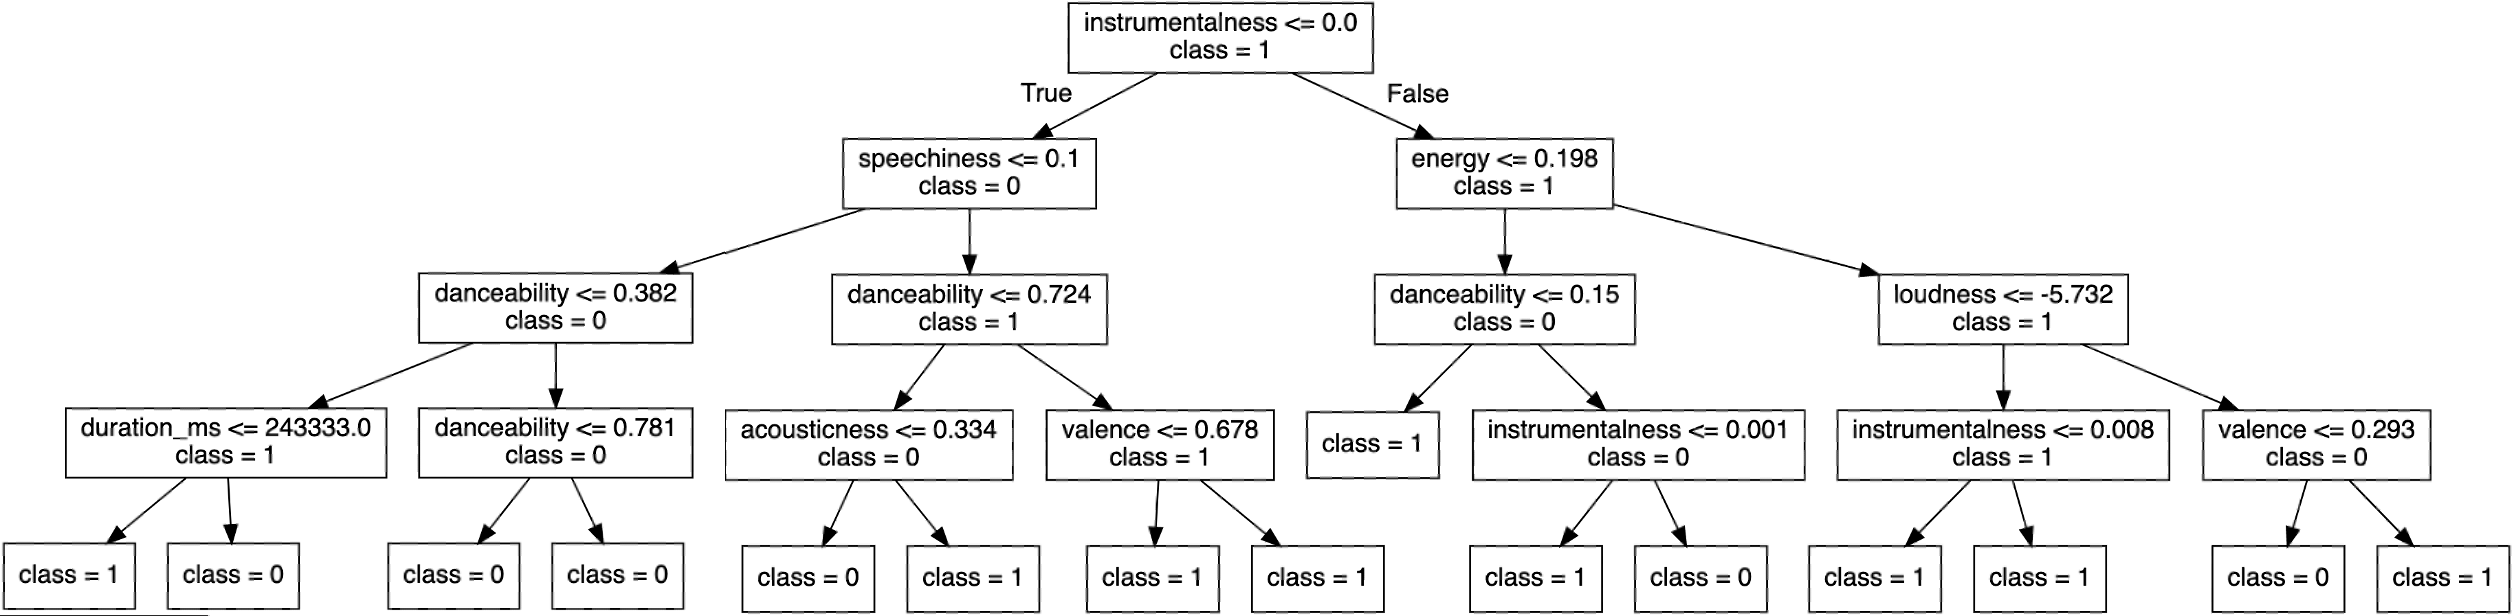

In [38]:
#display_tree(X.columns, model_spotify_max4)
Image('q5_1.png', width=1000)

### (Optional) 5.2 Exploring datasets and features
rubric={reasoning:1}

For each of the supervised machine learning problems listed below: 

- Flagging fraud transactions. 
- Getting sense of audiences' sentiment on a newly released movie or a product.
- Housing price predicting in Vancouver. 

Answer the following questions: 

1. List 4 to 8 features which could be useful to solve the problem. 
2. Find dataset(s) which could be useful to answer the question you are interested in answering. Here are some places you can look for datasets: [Kaggle](https://www.kaggle.com/), [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php). 
3. Comment on the quality/limitations of the dataset.  
4. Would it be worth collecting more data to answer your question better? 

**Flagging fraud transactions**
1. Customer personal information such as age, education, payment history, credit card registration location; transaction history such as transaction time, transaction location, , transaction amount
2. default of credit card clients Data Set  
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients  
Amount of the given credit, Education, Age, bill statement in the data set maybe useful to predict consumer behavior, the average amount that users spend in general basic on personal information. Hence detect abnormal amount of transaction.
3. 
- The data set is localized in Tai Wan. Users from different area might have different spending behavior.
- Bill statement is a lump sum, while single amount of transaction may vary a lot.
4. Depends on the purpose of the investigation. If a bank wants to use ML to detect fraud, it should have more internal data and worth to development. This data set is far from general and informative enough to develop a model to serve the purpose.  

**Getting sense of audiences' sentiment on a newly released movie or a product**  
1. review comments, movie director, actor list, movie producer
2. IMDB Dataset of 50K Movie Reviews   
https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?select=IMDB+Dataset.csv
3. The dataset only provide review comments, no movie information. But a good NLP library should be good to indicate sentiment values.
4. IMDB website also provides movie data, which is easy to use and analyze
https://www.imdb.com/interfaces/

**Housing price predicting in Vancouver**  
1.  Land classification, house price, year built, district
2.  Property tax report
https://opendata.vancouver.ca/explore/dataset/property-tax-report/information/
3. House price also basics on housing index, depends on the market. There may be difference if we use last year's data to predict current housing price. Therefore, the housing index should be taken into account. 
4. This data set should have enough information for housing prediction. Statistic Canada also provides monthly housing index. 
https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1810020501

**PLEASE READ BEFORE YOU SUBMIT:** 

When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from "1" will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Push all your work to your GitHub lab repository. 
4. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 
5. Make sure that the plots and output are rendered properly in your submitted file. 

### Congratulations on finishing lab 1! Well done 👏👏! 